In [1]:
!pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2024-06-03 14:11:14.641045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 14:11:14.641163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 14:11:14.765681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
2.15.0


In [3]:
!pip install -q vit-keras
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [4]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *
import keras
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,RocCurveDisplay

SEED = 42
IMG_SIZE = 224, 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Reading </span> Data

In [5]:
# creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


classes = {0: 'Benign', 1: 'Malignant'}

train_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Benign')
train_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Malignant')

full_data = pd.concat([pd.DataFrame({'image' : train_benign_imgs, 'label': 0 }),
                      pd.DataFrame({'image' : train_malignant_imgs, 'label': 1 })])
# shuffling dataset
full_data = full_data.sample(frac = 1, ignore_index = True, random_state = SEED)

# train and valid splitting
train_data, valid_data = train_test_split(full_data, test_size = 0.2, stratify = full_data['label'])

train_data = train_data.reset_index(drop = True)
valid_data = valid_data.reset_index(drop = True)

# test dataframe
test_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Benign')
test_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Malignant')

test_data = pd.concat([pd.DataFrame({'image' : test_benign_imgs, 'label': 0 }),
                       pd.DataFrame({'image' : test_malignant_imgs, 'label': 1 })])
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = SEED)


print('total train images \t{0}'.format(train_data.shape[0]))
print('total valid images \t{0}'.format(valid_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

total train images 	9503
total valid images 	2376
total test images 	2000


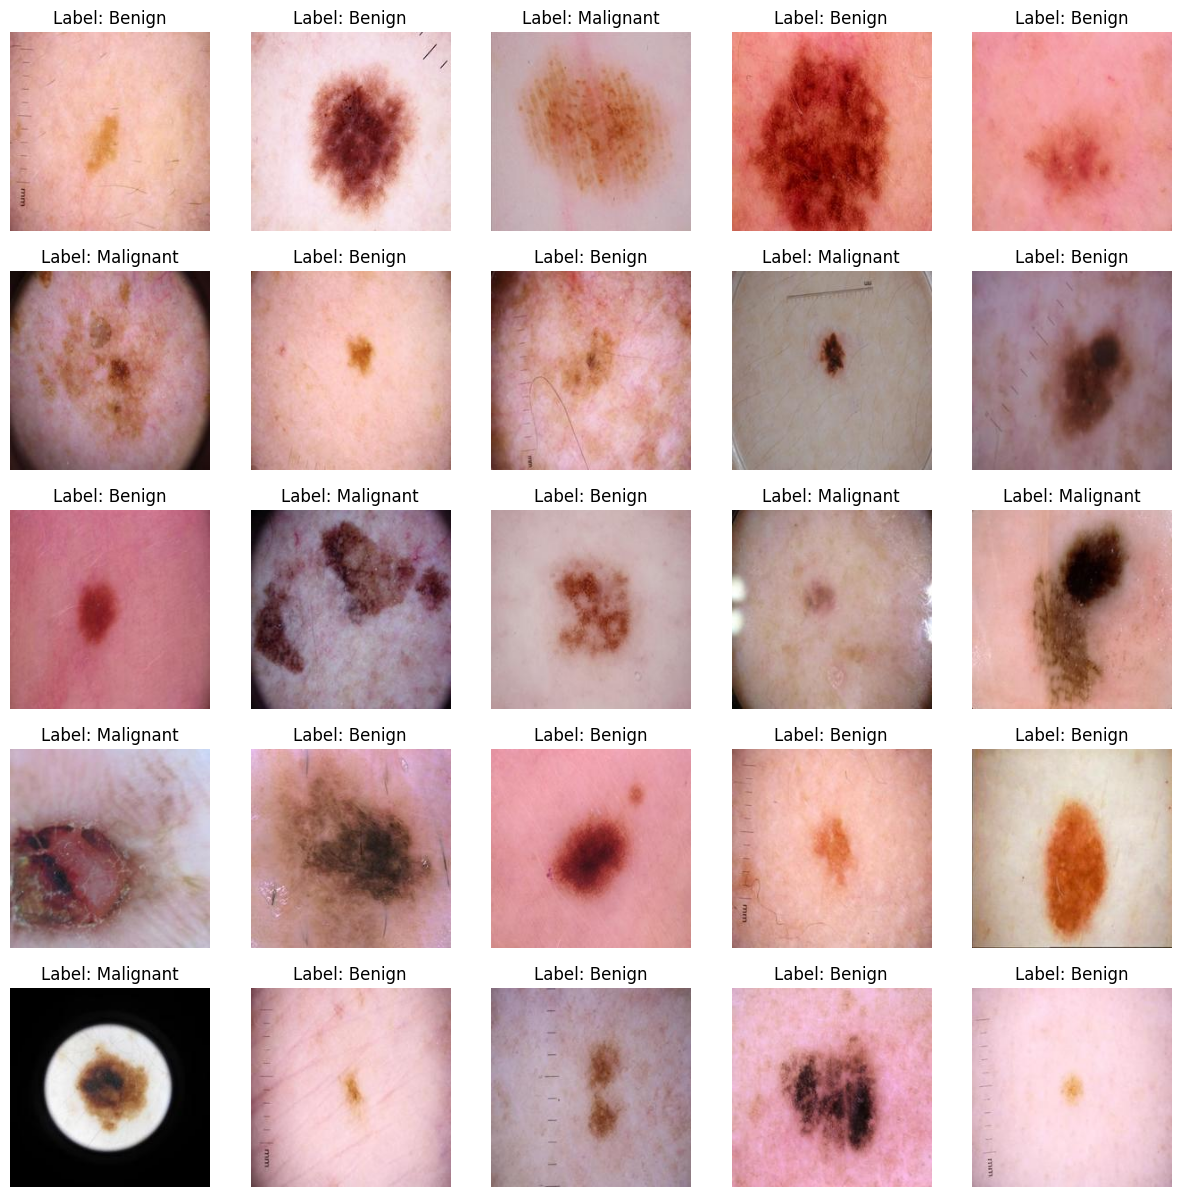

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Print 25 random samples from the training data with inferno colormap
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    random_index = np.random.randint(0, train_data.shape[0])
    img_path = train_data.loc[random_index, 'image']
    img = Image.open(img_path)
    plt.imshow(img)
    ax.set_title(f"Label: {classes[train_data.loc[random_index, 'label']]}")
    ax.axis('off')

plt.show()

In [7]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size =(IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0


    return img, label


# Data augmentation
img_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation((-0.3, 0.3), interpolation="bilinear"),
    RandomContrast(0.03),
    RandomCrop(*IMG_SIZE)])

In [8]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['image'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .map(lambda img, label: (img_augmentation(img), label), num_parallel_calls =AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['image'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

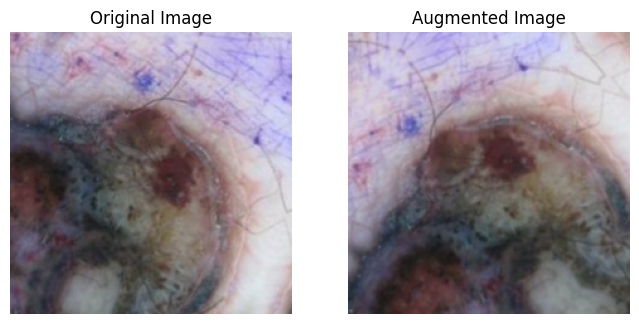

In [9]:
# Display original and augmented image for the first sample
def display_sample_images(dataset):
    for images, labels in dataset.take(1):
        # Display original image
        original_image = images[0].numpy()
        
        # Apply augmentation
        augmented_image = img_augmentation(images[0:1], training=True)[0].numpy()
        
        # Plotting
        plt.figure(figsize=(8, 4))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image,cmap='inferno')
        plt.axis("off")
        
        # Augmented image
        plt.subplot(1, 2, 2)
        plt.title("Augmented Image")
        plt.imshow(augmented_image,cmap='inferno')
        plt.axis("off")
        
        plt.show()
        break

# Display original and augmented images from train dataset
display_sample_images(train_dataset)

In [10]:
# a custom callback for evaluation of test set during training each 10 loop
class Test_Pred_During_Training(Callback):

    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epochs, logs = None ):
        try:
            if (epochs+1) % 10 == 0:
                test_pred = self.model.predict(test_dataset, verbose = 0)
                test_pred = np.argmax(test_pred, axis = 1)

                mse = mean_squared_error(test_data['label'], test_pred)
                f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
                acc = accuracy_score(test_data['label'], test_pred)

                print('\nMean Squared Error : {0:.5f}'.format(mse))
                print('Weighted F1 Score : {0:.3f}'.format(f1))
                print('Accuracy Score : {0:.3f} %'.format(acc*100))

                print("--"*40)
        except ValueError:
            pass

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Concatenate, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from vit_keras import vit

# Download the model
vit_model = vit.vit_b16(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=2
)

# Tạo mô hình Big Transfer từ URL
bit_model_url = "https://www.kaggle.com/models/google/bit/TensorFlow2/m-r101x3/1"
bit_model = hub.KerasLayer(bit_model_url, trainable=False)

for layer in vit_model.layers:
    layer.trainable = False

# Tạo input tensor
input_tensor = Input(shape=(224, 224, 3))

# Lấy đầu ra của Vision Transformer
vit_output = vit_model(input_tensor)

# Lấy đầu ra của Big Transfer
bit_output = bit_model(input_tensor)

# Kết hợp đầu ra của cả hai mô hình bằng lớp Concatenate
combined_output = Concatenate()([vit_output, bit_output])

# Tiếp tục với các lớp Dense
fusion_output = Dense(2048, activation='relu')(combined_output)
fusion_output = Dense(256, activation='relu')(fusion_output)
fusion_output = Dense(2, activation='softmax')(fusion_output)

# Tạo mô hình mới
fusion_model = Model(inputs=input_tensor, outputs=fusion_output)

# Compile mô hình
# fusion_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fusion_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                    metrics=['accuracy'])

# Hiển thị cấu trúc của mô hình
fusion_model.summary()


347502902/347502902 [==============================] - 1s 0us/step


Attaching model 'google/bit/tensorflow2/m-r101x3/1' to your Kaggle notebook...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b16 (Functional)        (None, 768)                  8579865   ['input_2[0][0]']             
                                                          6                                       
                                                                                                  
 keras_layer (KerasLayer)    (None, 6144)                 3817898   ['input_2[0][0]']             
                                                          88                                      
                                                                                              

In [12]:
my_callbacks = [Test_Pred_During_Training(fusion_model),
                tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor=0.1, min_delta = 0.01, patience=6),
#                 tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01,patience=20),
                tf.keras.callbacks.ModelCheckpoint("/kaggle/working/my_model.tf", monitor="val_loss", mode="min", save_best_only=True, verbose=1)]

In [13]:
import time
start = time.time()
history = fusion_model.fit(
    train_dataset,
    batch_size=32,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=[my_callbacks]
)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50


I0000 00:00:1717424018.063925      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8418
Epoch 1: val_loss improved from inf to 0.27176, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 541s 2s/step - loss: 0.3826 - accuracy: 0.8418 - val_loss: 0.2718 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.8804
Epoch 2: val_loss improved from 0.27176 to 0.26132, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 481s 2s/step - loss: 0.2728 - accuracy: 0.8804 - val_loss: 0.2613 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.8966
Epoch 3: val_loss improved from 0.26132 to 0.25202, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 480s 2s/step - loss: 0.2454 - accuracy: 0.8966 - val_loss: 0.2520 - val_accuracy: 0.8902 - lr: 0.0010
Epoc

# <span style="color:#e74c3c;"> Training </span> Results

In [14]:
# Print training results
print("Training Results:")
print("Loss:", history.history['loss'][-1])
print("Accuracy:", history.history['accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training Results:
Loss: 0.14577631652355194
Accuracy: 0.9433863162994385
Validation Loss: 0.21889659762382507
Validation Accuracy: 0.9061447978019714


Loss: Train Loss = 0.1458, Validation Loss = 0.2189


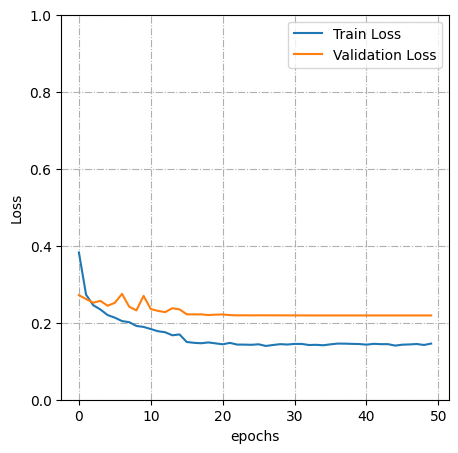

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

axs.grid(linestyle='dashdot')
axs.plot(history.history['loss'])
axs.plot(history.history['val_loss'])
axs.set_xlabel('epochs', fontsize=10)
axs.set_ylabel('Loss', fontsize=10)
axs.legend(['Train Loss', 'Validation Loss'], fontsize=10)
axs.set_ylim(0, 1)
print(f'Loss: Train Loss = {history.history["loss"][-1]:.4f}, Validation Loss = {history.history["val_loss"][-1]:.4f}')

Accuracy: Train Accuracy = 0.9434, Validation Accuracy = 0.9061


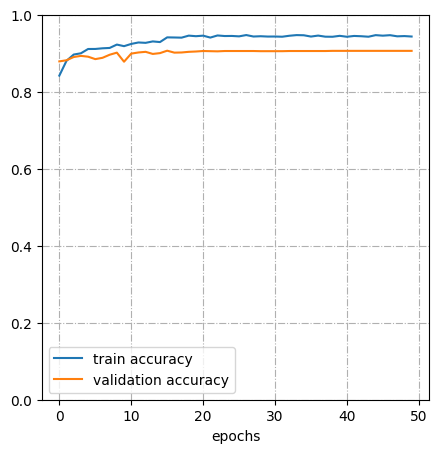

In [16]:
fig, axs = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
axs.grid(linestyle = 'dashdot')
axs.plot(history.history['accuracy'])
axs.plot(history.history['val_accuracy'])
axs.set_xlabel('epochs', fontsize = 10)
axs.legend(['train accuracy', 'validation accuracy'], fontsize = 10)
axs.set_ylim(0, 1)
print(f'Accuracy: Train Accuracy = {history.history["accuracy"][-1]:.4f}, Validation Accuracy = {history.history["val_accuracy"][-1]:.4f}')

# <span style="color:#e74c3c;"> Test </span> Prediction

In [17]:
# Predictions and scores
test_pred = fusion_model.predict(test_dataset)
test_pred = np.argmax(test_pred, axis = 1)

mse = mean_squared_error(test_data['label'], test_pred)
f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
acc = accuracy_score(test_data['label'], test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

63/63 [==============================] - 70s 1s/step
Mean Squared Error : 0.09150
Weighted F1 Score : 0.908
Accuracy Score : 90.850 %


# <span style="color:#e74c3c;"> Classification </span> Report

In [18]:
clf = classification_report(test_data['label'], test_pred, target_names = list(classes.values()))
print(clf)

              precision    recall  f1-score   support

      Benign       0.88      0.94      0.91      1000
   Malignant       0.94      0.88      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



# <span style="color:#e74c3c;"> Confusion </span> Maxtrix

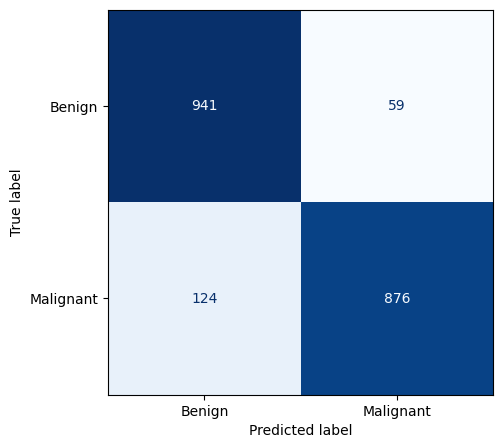

In [19]:
cm = confusion_matrix(test_data['label'], test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'Blues', colorbar = False)

# <span style="color:#e74c3c;"> Test </span> Results

In [20]:
# Evaluate the model on the test set
test_loss, test_acc = fusion_model.evaluate(test_dataset)

# Print test results
print("\nTest Results:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

63/63 [==============================] - 71s 1s/step - loss: 0.2242 - accuracy: 0.9085

Test Results:
Test Loss: 0.22415076196193695
Test Accuracy: 0.9085000157356262


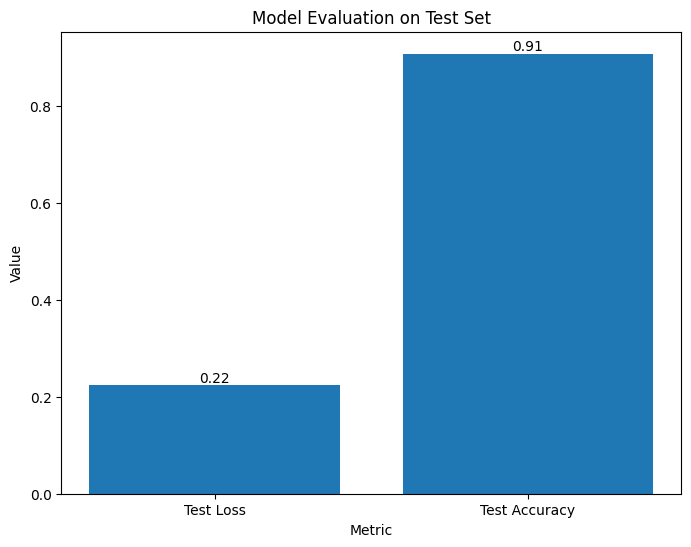

In [21]:
import matplotlib.pyplot as plt

# Create a bar chart
x = ['Test Loss', 'Test Accuracy']
y = [test_loss, test_acc]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, y)

# Add labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Model Evaluation on Test Set')

# Add value labels to the bars
for i, v in enumerate(y):
    ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

# <span style="color:#e74c3c;"> Test Set </span> Predictions

In [22]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs - batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        pred_label = int(test_pred[idx[i]])
        pred_prob = fusion_model.predict(tf.expand_dims(img, axis=0))[0][pred_label]

        if pred_label == label:
            axs[i].imshow(img, cmap='gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i]) + ')' + '\nTRUE: ' + classes[label] + '\nPRED: ' + classes[pred_label] + f' ({pred_prob:.2%})', fontsize=8, color='green')
        else:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i]) + ')' + '\nTRUE: ' + classes[label] + '\nPRED: ' + classes[pred_label] + f' ({pred_prob:.2%})', fontsize=8, color='red')

1/1 [==============================] - 0s 144ms/step


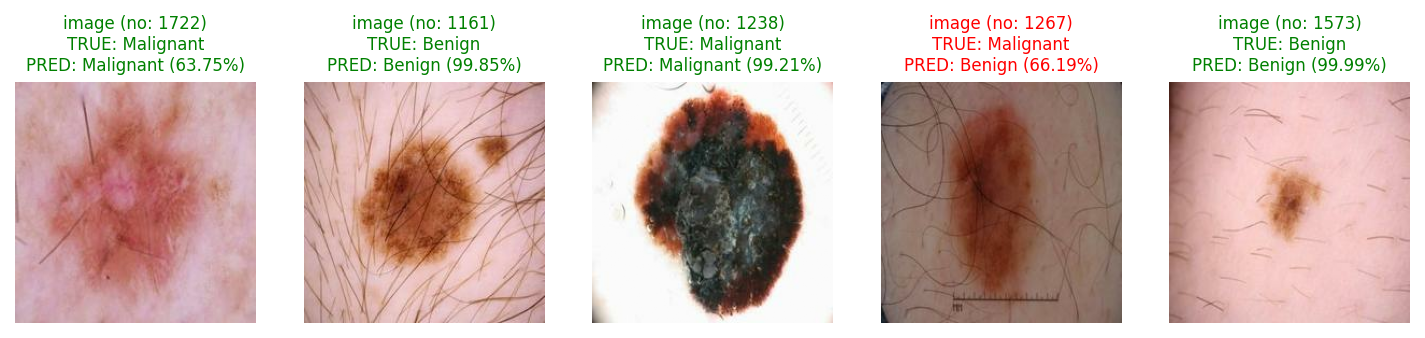

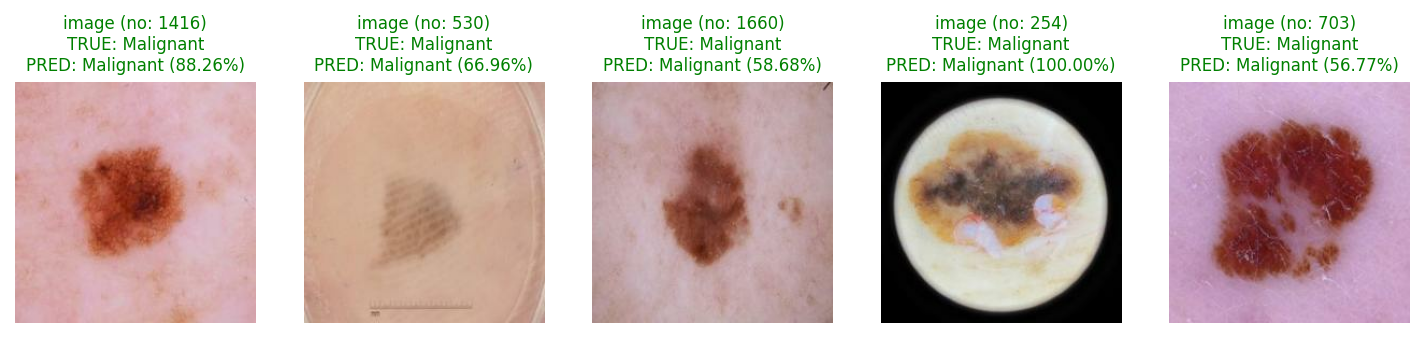

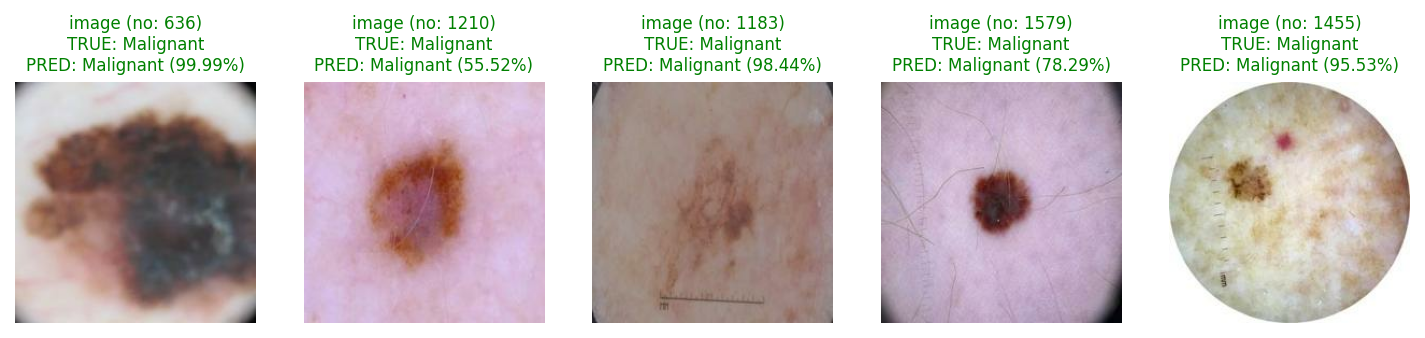

In [23]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(11)
random_test_sample_with_prediction(104)
random_test_sample_with_prediction(193)

In [24]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('/kaggle/working/my_model.tf')

1/1 [==============================] - 5s 5s/step


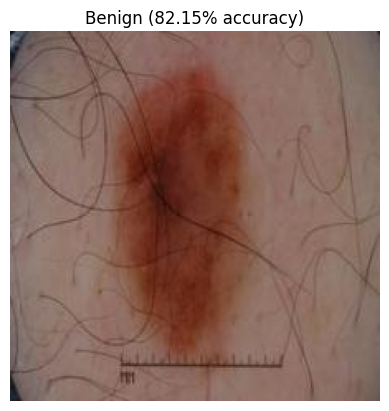

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 5742
test_image_path = '/kaggle/input/melanoma-cancer-dataset/test/Malignant/5742.jpg'

test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (224, 224))
test_image_display = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_normalized = test_image / 255.0
test_image_normalized = np.expand_dims(test_image_normalized, axis=0)

predictions = loaded_model.predict(test_image_normalized)
predicted_class_index = np.argmax(predictions)
if predicted_class_index == 0:
    predicted_class = 'Benign'
else:
    predicted_class = 'Malignant'

predicted_accuracy = np.max(predictions) *100

# if predicted_class_index == 1:
#     bounding_box = [50, 70, 150, 120]
#     cv2.rectangle(test_image_display, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (0, 255, 0), 2)

plt.imshow(test_image_display)
plt.title(f"{predicted_class} ({predicted_accuracy:.2f}% accuracy)")
plt.axis('off')
plt.show()